In [1]:
import pickle
import sys
sys.path.append("..")

In [2]:
import pandas as pd
data = pd.read_csv("../data/data.csv")
test_data = pd.read_csv("../data/ISCXURL2016/all_concated.csv")

In [3]:
#char level
from utils import vectorization
char_vectorizer =  vectorization.get_char_vectorizer(data["url"])

In [4]:
from utils.data_util import postpad_to
test_data_x = postpad_to(char_vectorizer.texts_to_sequences(test_data['url']), 200)

In [5]:
test_data_y = [1 if label == "bad" else 0 for label in test_data["label"]]

In [6]:
import tensorflow.keras as k

def create_conv_subnet(input_layer, conv_kernel_sizes, prefix=''):
    convolutions = list()
    for kernel_size in conv_kernel_sizes:
        x = k.layers.Conv1D(
            filters=32,
            kernel_size=kernel_size,
            padding='same',
            activation='relu',
            name=f'{prefix}_conv_{kernel_size}'
        )(input_layer)
        x = k.layers.MaxPool1D()(x)
        convolutions.append(x)

    x = k.layers.concatenate(convolutions, axis=2)
    x = k.layers.Flatten()(x)
    x = k.layers.Dropout(0.5, name=f'{prefix}_dropout')(x)
    x = k.layers.Dense(512, name=f'{prefix}_dense', activation='relu')(x)
    return x

def create_url_net(input_length, emb_dim, conv_kernel_sizes):
    char_input = k.layers.Input(shape=[input_length], name='char')

    x = create_conv_subnet(
        k.layers.Embedding(2+LC, emb_dim, mask_zero=True)(char_input),
        conv_kernel_sizes,
        'char'
    )

    x = k.layers.Dense(128, activation='relu', name='dense_1')(x)
    x = k.layers.Dense(1, activation='sigmoid', name='dense_comb_out')(x)

    model = k.models.Model(inputs=[char_input], outputs=[x])
    return model

LC = len(char_vectorizer.word_counts)
cnn_char_model = create_url_net(
    input_length=200,
    emb_dim=16,
    conv_kernel_sizes=[3,5]
)

In [7]:
cnn_char_model = k.models.load_model('./cnn_char_level')

In [12]:
test_pred_y = cnn_char_model.predict(test_data_x)

In [9]:
type(test_pred_y)

numpy.ndarray

In [17]:
test_pred_y_round = [1 if i > 0.5 else 0 for i in test_pred_y]

In [18]:
from sklearn.metrics import classification_report
print(classification_report(test_data_y, test_pred_y_round))

              precision    recall  f1-score   support

           0       0.22      0.98      0.35     35378
           1       0.85      0.04      0.07    129988

    accuracy                           0.24    165366
   macro avg       0.53      0.51      0.21    165366
weighted avg       0.72      0.24      0.13    165366



In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
import numpy as np

In [22]:
fpr, tpr, thresholds = roc_curve(test_data_y, test_pred_y)
auc_ = auc(fpr, tpr)
best_threshold = thresholds[np.argmax(-fpr + tpr)]
print("best threshold: ", best_threshold)

best threshold:  0.5074549


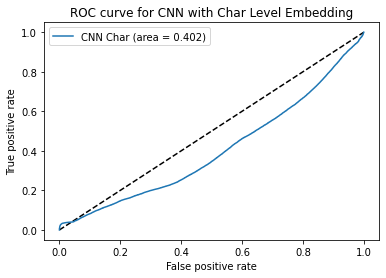

In [21]:
import matplotlib.pyplot as plt

model_name = "CNN Char"
model_full_name = "CNN with Char Level Embedding"

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'{model_name} (area = {auc_:.3f})')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve for {model_full_name}')
plt.legend(loc='best')
plt.savefig(f'../plots/{model_name.replace(" ", "_").lower()}_roc.pdf')
plt.show()